# Crashspot – Week 3 Starter
**Focus:** Spatial Clustering (DBSCAN) + Road Overlay (OSM) — Monroe, LA

**Deliverables this week**
- Clustered crashes (DBSCAN) saved as GeoJSON
- Cluster size summary & bar chart
- Folium map of clusters (categorical coloring)
- Roads with crash counts joined (per segment)
- Folium map of roads colored by crash count



In [7]:
# 0) Paths & folders
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent if (Path.cwd().name.startswith('Crashspot_')) else Path.cwd()

for p in ['data_raw/osm_roads', 'data_clean', 'outputs/maps', 'outputs/figures']:
    (PROJECT_ROOT / p).mkdir(parents=True, exist_ok=True)

MONROE_CLEAN = PROJECT_ROOT / 'data_clean' / 'fars_monroe_2022_2023_clean.geojson'
CLUSTERS_OUT = PROJECT_ROOT / 'data_clean' / 'fars_monroe_clusters.geojson'
CLUSTERS_MAP = PROJECT_ROOT / 'outputs' / 'maps' / 'week3_monroe_clusters.html'
ROADS_COUNTS_OUT = PROJECT_ROOT / 'data_clean' / 'monroe_roads_with_crash_counts.geojson'
ROADS_MAP = PROJECT_ROOT / 'outputs' / 'maps' / 'week3_monroe_roads_counts.html'

print('PROJECT_ROOT =', PROJECT_ROOT.resolve())
print('Monroe clean file:', MONROE_CLEAN.exists(), MONROE_CLEAN)

PROJECT_ROOT = /Users/himalranabhat/Desktop/Crashspot
Monroe clean file: True /Users/himalranabhat/Desktop/Crashspot/data_clean/fars_monroe_2022_2023_clean.geojson


In [8]:
# 1) Imports & versions
import sys, pandas as pd, numpy as np, geopandas as gpd, folium
import matplotlib.pyplot as plt
from shapely.geometry import Point, box
from sklearn.cluster import DBSCAN

print('Python:', sys.version.split()[0])
print('pandas', pd.__version__, '| geopandas', gpd.__version__)

Python: 3.12.2
pandas 2.2.2 | geopandas 1.1.1


## Load Monroe crashes (Week 1 output)

In [9]:
# 2) Load Monroe cleaned GeoJSON
if not MONROE_CLEAN.exists():
    raise FileNotFoundError(f'Missing {MONROE_CLEAN}. Create it in Week 1.')

monroe = gpd.read_file(MONROE_CLEAN)
monroe = monroe.dropna(subset=['geometry']).copy()

if monroe.crs is None or monroe.crs.to_epsg() != 4326:
    monroe = monroe.to_crs(4326)

print('Records:', len(monroe), '| CRS:', monroe.crs)
monroe.head(2)

Records: 60 | CRS: EPSG:4326


,STATE,STATENAME,ST_CASE,PEDS,PERNOTMVIT,VE_TOTAL,VE_FORMS,PVH_INVL,PERSONS,PERMVIT,...,ARR_HOUR,ARR_HOURNAME,ARR_MIN,ARR_MINNAME,HOSP_HR,HOSP_HRNAME,HOSP_MN,HOSP_MNNAME,FATALS,geometry
0,22,Louisiana,220044,0,0,2,2,0,3,3,...,6,6:00am-6:59am,40,40,7,7:00am-7:59am,9,9,1,POINT (-92.16463 32.48496)
1,22,Louisiana,220046,1,1,1,1,0,3,3,...,22,10:00pm-10:59pm,30,30,22,10:00pm-10:59pm,45,45,1,POINT (-92.08659 32.46445)


## Project to meters CRS (UTM 15N) for DBSCAN

In [10]:
# 3) Project to UTM zone 15N (EPSG:32615) ~ suitable for Monroe, LA (lon ~ -92)
MONROE_METRIC = monroe.to_crs(32615)
coords = np.vstack([MONROE_METRIC.geometry.x.values, MONROE_METRIC.geometry.y.values]).T
coords[:3], MONROE_METRIC.crs

(array([[ 578487.89642866, 3594499.04258006],
        [ 585840.3728439 , 3592285.66319331],
        [ 581460.01192437, 3598645.36072689]]),
 <Projected CRS: EPSG:32615>
 Name: WGS 84 / UTM zone 15N
 Axis Info [cartesian]:
 - E[east]: Easting (metre)
 - N[north]: Northing (metre)
 Area of Use:
 - name: Between 96°W and 90°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Manitoba; Nunavut; Ontario. Ecuador -Galapagos. Guatemala. Mexico. United States (USA).
 - bounds: (-96.0, 0.0, -90.0, 84.0)
 Coordinate Operation:
 - name: UTM zone 15N
 - method: Transverse Mercator
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

## DBSCAN clustering
- `eps` is neighborhood radius **in meters** (here: 600 m)
- `min_samples` is min points to form a cluster (here: 3)

In [11]:
# 4) Run DBSCAN
eps_m = 600
min_samples = 3

db = DBSCAN(eps=eps_m, min_samples=min_samples)
labels = db.fit_predict(coords)
MONROE_METRIC['cluster_id'] = labels

monroe_clusters = MONROE_METRIC.to_crs(4326)[monroe.columns.tolist() + ['cluster_id']]

n_noise = int((labels == -1).sum())
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f'Clusters found: {n_clusters} | Noise points: {n_noise}')

sizes = pd.Series(labels)[pd.Series(labels) != -1].value_counts().sort_index()
sizes.head()

Clusters found: 1 | Noise points: 57


0    3
Name: count, dtype: int64

## Save clustered crashes

In [12]:
# 5) Save clustered Monroe crashes
monroe_clusters.to_file(CLUSTERS_OUT, driver='GeoJSON')
print('Saved:', CLUSTERS_OUT)

Saved: /Users/himalranabhat/Desktop/Crashspot/data_clean/fars_monroe_clusters.geojson


## Visualize cluster sizes

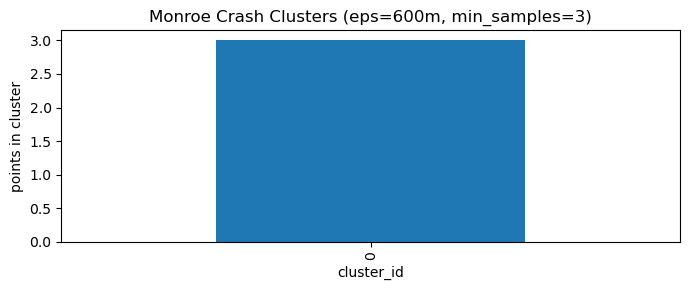

Saved: /Users/himalranabhat/Desktop/Crashspot/outputs/figures/monroe_cluster_sizes.png


In [13]:
# 6) Bar chart of cluster sizes
if not sizes.empty:
    plt.figure(figsize=(7,3))
    sizes.plot(kind='bar')
    plt.title(f'Monroe Crash Clusters (eps={eps_m}m, min_samples={min_samples})')
    plt.xlabel('cluster_id'); plt.ylabel('points in cluster')
    plt.tight_layout()
    out_png = PROJECT_ROOT / 'outputs' / 'figures' / 'monroe_cluster_sizes.png'
    plt.savefig(out_png, dpi=200); plt.show()
    print('Saved:', out_png)
else:
    print('No clusters (all noise). Try increasing eps or lowering min_samples.')

## Folium map of clusters (categorical colors)

In [14]:
# 7) Folium map (robust colors for cluster ids)
import random
import pandas as pd

uniq = sorted([
    int(c) for c in pd.Series(monroe_clusters['cluster_id']).dropna().unique()
    if int(c) != -1
])

palette = {}
for cid in uniq:
    rng = random.Random(int(cid))  # local seed per cluster id
    palette[int(cid)] = '#%02x%02x%02x' % (
        rng.randint(0,255), rng.randint(0,255), rng.randint(0,255)
    )
palette[-1] = '#666666'  # noise

center = [monroe_clusters.geometry.y.mean(), monroe_clusters.geometry.x.mean()]
m = folium.Map(location=center, zoom_start=12, tiles='OpenStreetMap')

for _, row in monroe_clusters.iterrows():
    pt = row.geometry
    cid = row['cluster_id']
    cid = int(cid) if pd.notna(cid) else -1
    folium.CircleMarker(
        location=[pt.y, pt.x],
        radius=4,
        color=palette.get(cid, '#000'),
        fill=True, fill_opacity=0.7,
        popup=folium.Popup(
            f"Cluster: {cid}<br>Year: {row.get('YEAR','')}"
            f"<br>Hour: {row.get('HOUR','')}", max_width=200
        )
    ).add_to(m)

m.save(str(CLUSTERS_MAP))
m


## OSMnx code

In [15]:
# (Optional) Download Monroe roads via OSMnx if Geofabrik file not available
import osmnx as ox
import geopandas as gpd

# Download driving roads for Monroe, LA
G = ox.graph_from_place("Monroe, Louisiana, USA", network_type="drive")

# Convert to GeoDataFrame of road segments
roads_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True)

# Save into your raw data folder
roads_path = PROJECT_ROOT / "data_raw" / "osm_roads" / "monroe_roads.geojson"
roads_gdf.to_file(roads_path, driver="GeoJSON")
print("Saved Monroe roads to:", roads_path)


Saved Monroe roads to: /Users/himalranabhat/Desktop/Crashspot/data_raw/osm_roads/monroe_roads.geojson


## Load OSM roads (Geofabrik)

In [20]:
# 8) Load OSM roads from data_raw/osm_roads
import os, geopandas as gpd

roads_dir = PROJECT_ROOT / 'data_raw' / 'osm_roads'
candidate = None
for ext in ['.gpkg', '.shp', '.geojson']:
    for p in roads_dir.rglob(f'*{ext}'):
        if 'roads' in p.name.lower() or 'lines' in p.name.lower():
            candidate = p
            break
    if candidate: break

if candidate is None:
    print('⚠️ Could not find OSM roads file in data_raw/osm_roads/. Place a .gpkg or .shp there.')
else:
    print('Found roads file:', candidate)

roads = gpd.read_file(candidate) if candidate else None
if roads is not None and (roads.crs is None or roads.crs.to_epsg() != 4326):
    roads = roads.to_crs(4326)

roads.head(2) if roads is not None else None

Skipping field highway: unsupported OGR type: 5
Skipping field name: unsupported OGR type: 5
Skipping field lanes: unsupported OGR type: 5
Skipping field maxspeed: unsupported OGR type: 5


Found roads file: /Users/himalranabhat/Desktop/Crashspot/data_raw/osm_roads/monroe_roads.geojson


,u,v,key,osmid,oneway,reversed,length,ref,bridge,tunnel,junction,geometry
0,115879540,115917164,0,12692563,False,False,392.712443,None,None,None,None,"LINESTRING (-92.11457 32.47932, -92.11851 32.4..."
1,115879540,115905079,0,12692563,False,True,156.690959,None,None,None,None,"LINESTRING (-92.11457 32.47932, -92.11301 32.4..."


## Clip roads to Monroe extent

In [21]:
# 9) Clip roads to bbox around the crashes
from shapely.geometry import box

if roads is not None:
    minx, miny, maxx, maxy = monroe_clusters.total_bounds
    pad = 0.02  # ~2 km padding
    bbox = box(minx-pad, miny-pad, maxx+pad, maxy+pad)
    roads_clip = roads[roads.intersects(bbox)].copy()
    print('Roads before/after clip:', len(roads), len(roads_clip))
else:
    roads_clip = None
roads_clip.head(2) if roads_clip is not None else None

Roads before/after clip: 7638 7638


,u,v,key,osmid,oneway,reversed,length,ref,bridge,tunnel,junction,geometry
0,115879540,115917164,0,12692563,False,False,392.712443,None,None,None,None,"LINESTRING (-92.11457 32.47932, -92.11851 32.4..."
1,115879540,115905079,0,12692563,False,True,156.690959,None,None,None,None,"LINESTRING (-92.11457 32.47932, -92.11301 32.4..."


## Join crash counts to road segments

In [22]:
# 10) Nearest-join crashes to road segments (within 30 m), count per segment
if roads_clip is not None:
    roads_m = roads_clip.to_crs(32615)
    pts_m = monroe_clusters.to_crs(32615)

    try:
        joined = gpd.sjoin_nearest(pts_m[['geometry']], roads_m[['geometry']], how='left', max_distance=30, distance_col='dist_m')
        counts = joined.groupby(joined.index_right).size().rename('crash_count')
        roads_m['crash_count'] = counts
        roads_m['crash_count'] = roads_m['crash_count'].fillna(0).astype(int)
    except Exception as e:
        print('sjoin_nearest failed, fallback to buffer join:', e)
        roads_buf = roads_m.copy()
        roads_buf['geometry'] = roads_buf.buffer(20)
        joined = gpd.sjoin(pts_m[['geometry']], roads_buf, how='left', predicate='within')
        counts = joined.groupby(joined.index_right).size().rename('crash_count')
        roads_m['crash_count'] = counts
        roads_m['crash_count'] = roads_m['crash_count'].fillna(0).astype(int)

    roads_counts = roads_m.to_crs(4326)
    roads_counts.to_file(ROADS_COUNTS_OUT, driver='GeoJSON')
    print('Saved:', ROADS_COUNTS_OUT)
else:
    roads_counts = None

Saved: /Users/himalranabhat/Desktop/Crashspot/data_clean/monroe_roads_with_crash_counts.geojson


## Folium map: roads colored by crash count

In [23]:
# 11) Map roads with crash_count
if roads_counts is not None:
    m2 = folium.Map(location=center, zoom_start=12, tiles='OpenStreetMap')
    def color_for(n):
        if n >= 10: return '#d73027'
        if n >= 5:  return '#fc8d59'
        if n >= 2:  return '#fee090'
        if n >= 1:  return '#e0f3f8'
        return '#cccccc'

    for _, r in roads_counts.iterrows():
        geom = r.geometry
        col = color_for(r.get('crash_count', 0))
        folium.GeoJson(geom.__geo_interface__, style_function=lambda _g, col=col: {'color': col, 'weight': 3}).add_to(m2)

    m2.save(str(ROADS_MAP))
    m2
else:
    print('No roads_counts to map.')